### Data Preprocessing

In [17]:
import preprocessor
import demoji
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load and preprocess your dataset
def preprocess_text(text):
    # Use tweet-preprocessor to clean tweets
    cleaned_text = preprocessor.clean(text)
    # Remove emojis
    cleaned_text = remove_emojis(cleaned_text)
    return cleaned_text

def remove_emojis(text):
    return demoji.replace(text, '')

# Load your dataset with columns 'tweet' and 'categories'
df = pd.read_csv("/Users/Hsuweic/Desktop/AI4health/dataset/training dataset.csv")
hate_speech = df[df['label'] == 1].copy() 
# Reset the index to ensure it is consecutive
hate_speech.reset_index(drop=True, inplace=True)

# Preprocess text
hate_speech['cleaned_tweet'] = hate_speech['tweet'].apply(preprocess_text)

print(hate_speech.shape)
print(hate_speech.columns)
print(len(hate_speech))

(1516, 5)
Index(['number', 'tweet', 'label', 'categories', 'cleaned_tweet'], dtype='object')
1516


In [18]:
# Convert categories to numerical labels
label_dict = {category: idx for idx, category in enumerate(hate_speech['categories'].unique())}
hate_speech['label'] = hate_speech['categories'].map(label_dict)

# Print label_dict to see the mapping
print("Label Dictionary:")
print(label_dict)
print(hate_speech.head(10))

Label Dictionary:
{'Race': 0, 'Sexual Orientation': 1, 'Gender': 2, 'Disability': 3, 'Class': 4, 'Ethnicity': 5, 'Physical Appearance': 6, 'Religion': 7, 'Behavior': 8}
   number                                              tweet  label   
0    2785  white kids favorite activities calling people ...      0  \
1     192                                             nigger      0   
2    4300  yall hire colored folk only work half da day a...      0   
3    5090               aight game over dykes had to ruin it      1   
4    3090  tajiana only fuck niggas would wanna continue ...      2   
5    4700       cant take u coons nowhere amp i mean nowhere      0   
6    4849  i really get upset when my lightskin friends h...      0   
7    3364  gt tragedy smh rt  niggas dont know you but wi...      2   
8     945  between this trend and the vines acting like w...      1   
9     808                      mcadams because ians retarded      3   

           categories                            

In [19]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test_temp, y_train, y_test_temp = train_test_split(
    hate_speech['cleaned_tweet'],  # Features
    hate_speech['label'],  # Labels
    test_size=0.4, 
    random_state=42
)

# Split the testing set into validation (50%) and testing (50%)
X_val, X_test, y_val, y_test = train_test_split(
    X_test_temp,
    y_test_temp,
    test_size=0.5,
    random_state=42
)

# Reset the index to ensure it is consecutive
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Print the sizes of each set: Training 60% / Val 20% / Testing 20% 
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))

Training set size: 909
Validation set size: 303
Testing set size: 304


### Logistic Regression + Softmax

Logistic Regression with Softmax:
                     precision    recall  f1-score   support

               Race       0.51      0.93      0.66        90
 Sexual Orientation       0.94      0.86      0.90        92
             Gender       0.69      0.64      0.66        55
         Disability       1.00      0.08      0.15        12
              Class       1.00      0.07      0.13        14
          Ethnicity       0.00      0.00      0.00         9
Physical Appearance       0.00      0.00      0.00        14
           Religion       0.00      0.00      0.00        10
           Behavior       0.00      0.00      0.00         8

           accuracy                           0.66       304
          macro avg       0.46      0.29      0.28       304
       weighted avg       0.64      0.66      0.60       304



/Users/Hsuweic/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Hsuweic/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Hsuweic/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


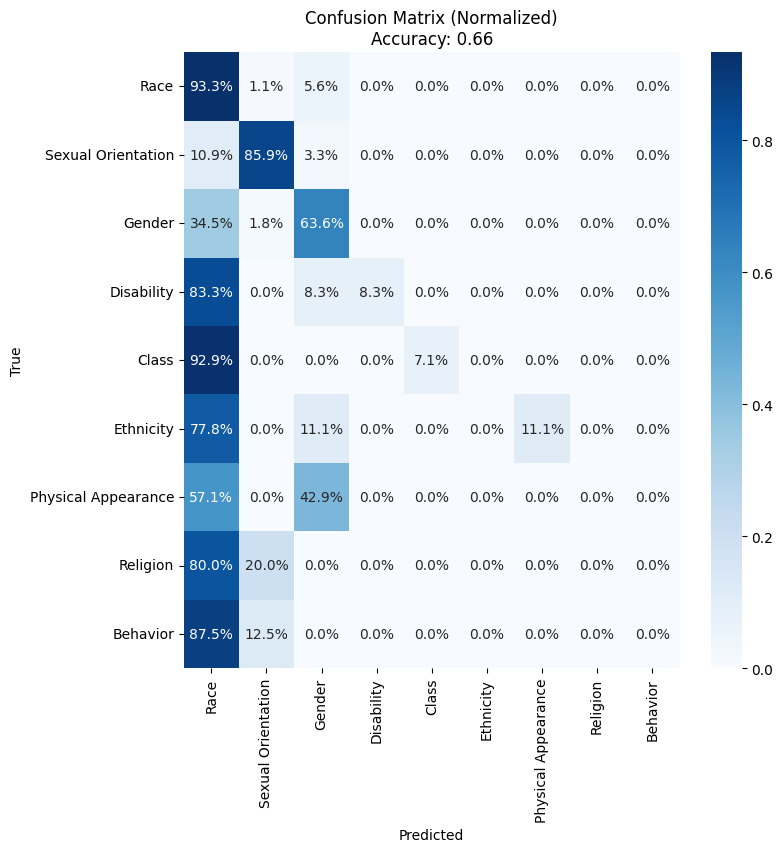

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Combine X_train and X_val into a single set for the model training
X_train_LRmax = pd.concat([X_train, X_val], ignore_index=True)
y_train_LRmax = pd.concat([y_train, y_val], ignore_index=True)

# Transform the text data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_LRmax)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Logistic Regression with multinomial (softmax)
logreg_multinomial = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)

# Model training
logreg_multinomial.fit(X_train_tfidf, y_train_LRmax)

# Predictions on the test set
y_pred_multinomial = logreg_multinomial.predict(X_test_tfidf)

# Evaluate the model with multinomial (softmax)
print("Logistic Regression with Softmax:")
print(classification_report(y_test, y_pred_multinomial, target_names=label_dict.keys()))

# Generate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_multinomial, normalize='true')  # Normalize the confusion matrix
accuracy_lrmax = accuracy_score(y_test, y_pred_multinomial)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys(), fmt=".1%")
plt.title(f'Confusion Matrix (Normalized)\nAccuracy: {accuracy_lrmax:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### BERTweet model

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load BERTweet model and tokenizer
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

hate_categories = 9  # Number of categories
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=hate_categories)

/Users/Hsuweic/Library/Python/3.8/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
from torch.utils.data import DataLoader, TensorDataset

def tokenize_data(text):
    return tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

# Tokenize and prepare input data for training set
tokenized_train = X_train.apply(tokenize_data)
print(len(tokenized_train))
print(tokenized_train.head(3))
tokenized_val = X_val.apply(tokenize_data)
print(len(tokenized_val))
print(tokenized_val.head(3))

# Create DataLoader for training set
input_ids_train = torch.cat([tokenized_train[i]['input_ids'] for i in range(len(tokenized_train))], dim=0)
attention_masks_train = torch.cat([tokenized_train[i]['attention_mask'] for i in range(len(tokenized_train))], dim=0)
labels_train = torch.tensor(y_train.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataloader_train = DataLoader(dataset_train, batch_size=8, shuffle=True)

# Create DataLoader for validation set
input_ids_val = torch.cat([tokenized_val[i]['input_ids'] for i in range(len(tokenized_val))], dim=0)
attention_masks_val = torch.cat([tokenized_val[i]['attention_mask'] for i in range(len(tokenized_val))], dim=0)
labels_val = torch.tensor(y_val.values)

dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataloader_val = DataLoader(dataset_val, batch_size=8, shuffle=False)

909
0    [input_ids, token_type_ids, attention_mask]
1    [input_ids, token_type_ids, attention_mask]
2    [input_ids, token_type_ids, attention_mask]
Name: cleaned_tweet, dtype: object
303
0    [input_ids, token_type_ids, attention_mask]
1    [input_ids, token_type_ids, attention_mask]
2    [input_ids, token_type_ids, attention_mask]
Name: cleaned_tweet, dtype: object


In [6]:
#setup before model training
from torch.nn import CrossEntropyLoss

# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()

# Set up training parameters
num_epochs = 5  # You can adjust this based on your requirements
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model and data to the device
model.to(device)
input_ids_train, attention_masks_train, labels_train = input_ids_train.to(device), attention_masks_train.to(device), labels_train.to(device)
input_ids_val, attention_masks_val, labels_val = input_ids_val.to(device), attention_masks_val.to(device), labels_val.to(device)
loss_per_epoch = {'train': [], 'val': []}
accuracy_per_epoch = {'train': [], 'val': []}

Training Epoch 1/5: 100%|██████████| 114/114 [27:02<00:00, 14.23s/it]


Epoch 1/5, Train Loss: 1.3785381505363865, Train Accuracy: 0.5643564356435643


Validation Epoch 1/5: 100%|██████████| 38/38 [03:00<00:00,  4.74s/it]


Epoch 1/5, Validation Loss: 0.7616523023890821, Validation Accuracy: 0.7854785478547854


Training Epoch 2/5: 100%|██████████| 114/114 [28:28<00:00, 14.99s/it]


Epoch 2/5, Train Loss: 0.8252370975780905, Train Accuracy: 0.7634763476347635


Validation Epoch 2/5: 100%|██████████| 38/38 [03:15<00:00,  5.15s/it]


Epoch 2/5, Validation Loss: 0.6744670091490996, Validation Accuracy: 0.7986798679867987


Training Epoch 3/5: 100%|██████████| 114/114 [58:21<00:00, 30.72s/it]


Epoch 3/5, Train Loss: 0.5868365127397212, Train Accuracy: 0.8404840484048405


Validation Epoch 3/5: 100%|██████████| 38/38 [08:43<00:00, 13.78s/it]


Epoch 3/5, Validation Loss: 0.6725471625594717, Validation Accuracy: 0.801980198019802


Training Epoch 4/5: 100%|██████████| 114/114 [50:56<00:00, 26.81s/it] 


Epoch 4/5, Train Loss: 0.3848330162204148, Train Accuracy: 0.8976897689768977


Validation Epoch 4/5: 100%|██████████| 38/38 [02:58<00:00,  4.71s/it]


Epoch 4/5, Validation Loss: 0.5661986134946346, Validation Accuracy: 0.8382838283828383


Training Epoch 5/5: 100%|██████████| 114/114 [30:04<00:00, 15.83s/it]


Epoch 5/5, Train Loss: 0.2901703363545893, Train Accuracy: 0.9174917491749175


Validation Epoch 5/5: 100%|██████████| 38/38 [02:41<00:00,  4.26s/it]


Epoch 5/5, Validation Loss: 0.5776467028466102, Validation Accuracy: 0.8481848184818482


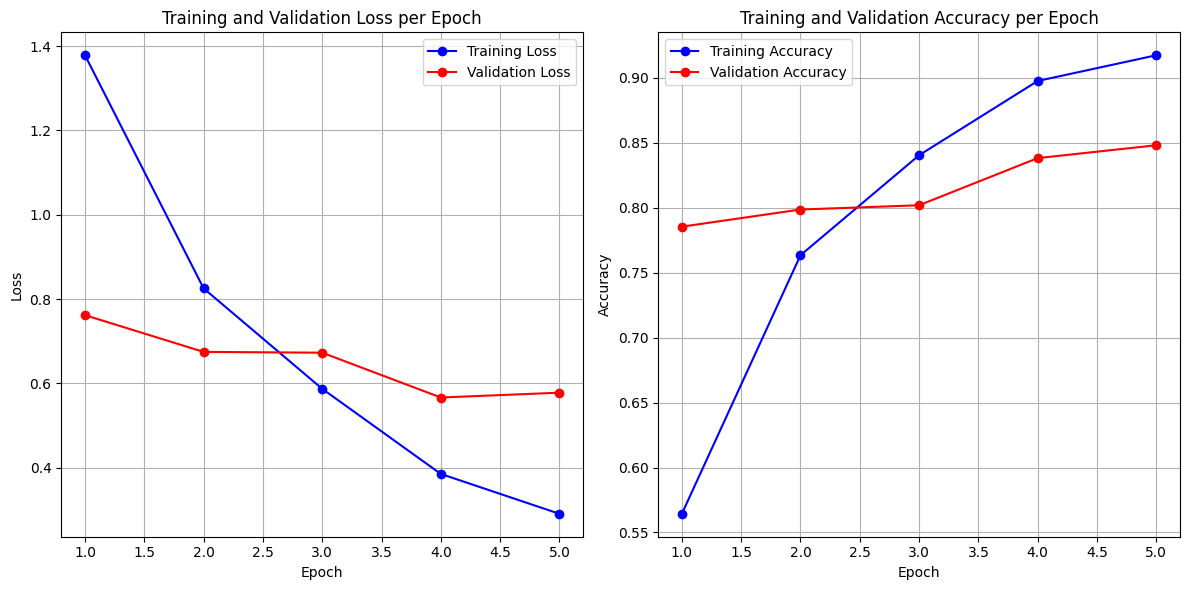

In [7]:
from tqdm import tqdm

# Model Training
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(dataloader_train, desc=f'Training Epoch {epoch + 1}/{num_epochs}'):
        batch_input_ids, batch_attention_masks, batch_labels = batch
        batch_input_ids, batch_attention_masks, batch_labels = (
            batch_input_ids.to(device),
            batch_attention_masks.to(device),
            batch_labels.to(device),
        )

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_masks,
            labels=batch_labels,
        )

        # Calculate loss
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        total_loss += loss.item()

        # Calculate training accuracy
        _, predicted_labels = torch.max(outputs.logits, 1)
        correct_predictions += (predicted_labels == batch_labels).sum().item()
        total_samples += batch_labels.size(0)

    # Calculate accuracy for the training epoch
    accuracy_train = correct_predictions / total_samples
    accuracy_per_epoch['train'].append(accuracy_train)

    # Calculate average loss for the training epoch
    average_loss_train = total_loss / len(dataloader_train)
    loss_per_epoch['train'].append(average_loss_train)
   
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_loss_train}, Train Accuracy: {accuracy_train}")

    # Validation
    model.eval()  # Set the model to evaluation mode
    total_loss_val = 0
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():  # Disable gradient computation during validation
        for batch_val in tqdm(dataloader_val, desc=f'Validation Epoch {epoch + 1}/{num_epochs}'):
            batch_input_ids, batch_attention_masks, batch_labels = batch_val
            batch_input_ids, batch_attention_masks, batch_labels = (
                batch_input_ids.to(device),
                batch_attention_masks.to(device),
                batch_labels.to(device),
            )
            outputs = model(
                    input_ids=batch_input_ids,
                    attention_mask=batch_attention_masks,
                    labels=batch_labels,
                )

            loss_val = outputs.loss
            total_loss_val += loss_val.item()

            _, predicted_labels_val = torch.max(outputs.logits, 1)
            correct_predictions_val += (predicted_labels_val == batch_labels).sum().item()
            total_samples_val += batch_labels.size(0)

    # Calculate accuracy for the validation epoch
    accuracy_val = correct_predictions_val / total_samples_val
    accuracy_per_epoch['val'].append(accuracy_val)

    # Calculate average loss for the validation epoch
    average_loss_val = total_loss_val / len(dataloader_val)
    loss_per_epoch['val'].append(average_loss_val)

    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {average_loss_val}, Validation Accuracy: {accuracy_val}")

# Save the trained model (This method is specific to the transformers library and is designed for saving transformer-based models.)
# It saves the model in a format that includes the architecture, parameters, and additional information specific to the transformers library.
# It provides a higher-level abstraction that is specific to transformer models and allows for easily loading the model using AutoModelForSequenceClassification.from_pretrained later.
model.save_pretrained("/Users/Hsuweic/Desktop/AI4health/model/classification model_4")
tokenizer.save_pretrained("/Users/Hsuweic/Desktop/AI4health/model/classification model_4")

# Plot the loss values
plt.figure(figsize=(12, 6))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_per_epoch['train'], label='Training Loss', marker='o', linestyle='-', color='b')
plt.plot(range(1, num_epochs + 1), loss_per_epoch['val'], label='Validation Loss', marker='o', linestyle='-', color='r')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracy_per_epoch['train'], label='Training Accuracy', marker='o', linestyle='-', color='b')
plt.plot(range(1, num_epochs + 1), accuracy_per_epoch['val'], label='Validation Accuracy', marker='o', linestyle='-', color='r')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# trained model
# lr = 5e-5
# batch size = 8
# epoch = 10
# total training time = 331 mins
# optimizer = AdamW

# Load the BERTweet tokenizer and model for sequence classification
model_path = "/Users/Hsuweic/Desktop/AI4health/model/classification model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=9)  # hate_categories = 9

BERTweet:
                     precision    recall  f1-score   support

               Race       0.80      0.91      0.85        90
 Sexual Orientation       0.94      0.98      0.96        92
             Gender       0.80      0.71      0.75        55
         Disability       0.67      0.83      0.74        12
              Class       0.82      0.64      0.72        14
          Ethnicity       0.71      0.56      0.63         9
Physical Appearance       0.67      0.43      0.52        14
           Religion       0.62      0.50      0.56        10
           Behavior       0.43      0.38      0.40         8

           accuracy                           0.82       304
          macro avg       0.72      0.66      0.68       304
       weighted avg       0.81      0.82      0.81       304



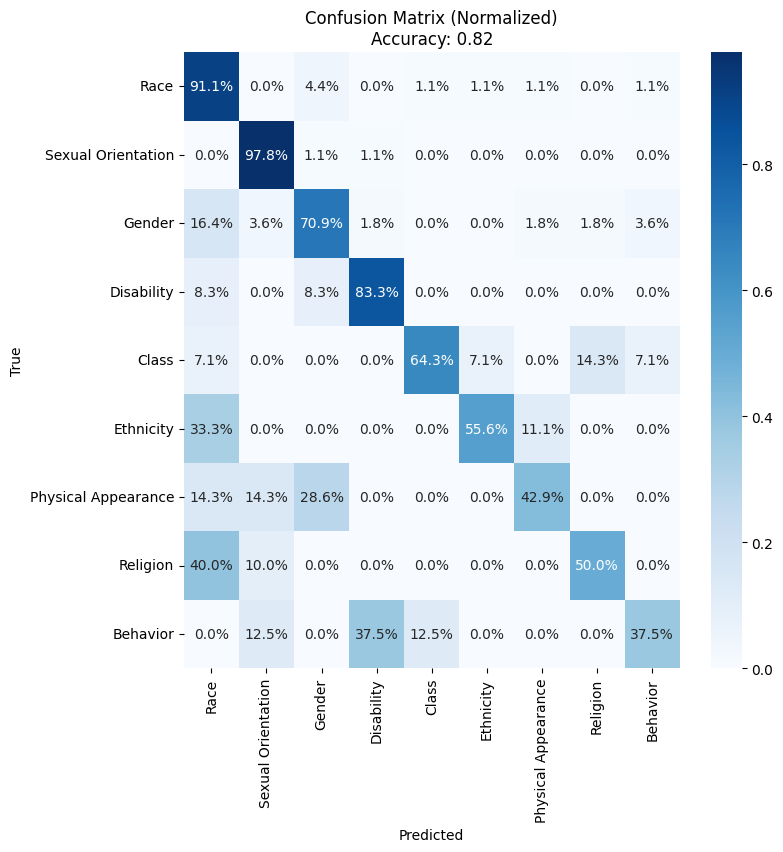

In [16]:
# Tokenize and prepare input data for testing set
# tokenized_test = tokenizer(X_test, return_tensors="pt")
tokenized_test = X_test.apply(tokenize_data)
# print(len(tokenized_test))
# print(tokenized_test)

input_ids_test = torch.cat([tokenized_test[i]['input_ids'] for i in range(len(tokenized_test))], dim=0)
attention_masks_test = torch.cat([tokenized_test[i]['attention_mask'] for i in range(len(tokenized_test))], dim=0)
labels_test = torch.tensor(y_test.values)

# Create DataLoader for testing set
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
dataloader_test = DataLoader(dataset_test, batch_size=8, shuffle=False)

# Evaluation loop
model.eval()
all_preds = []

with torch.no_grad():
    for batch in dataloader_test:
        input_ids, attention_masks, labels = [tensor.to(device) for tensor in batch]

        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)

# Evaluate the model
print("BERTweet:")
print(classification_report(y_test, all_preds, target_names=label_dict.keys()))

# Generate confusion matrix
conf_mat = confusion_matrix(y_test, all_preds, normalize='true')  # Normalize the confusion matrix
accuracy_bertweet = accuracy_score(y_test, all_preds)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys(), fmt=".1%")
plt.title(f'Confusion Matrix (Normalized)\nAccuracy: {accuracy_bertweet:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()